In [4]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib as mpl

from functools import partial

import time
import scipy.stats as stats
import seaborn as sns
import arviz as az

#import constants

from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

pd.set_option('display.max_columns', None)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

/opt/anaconda3/envs/Boda_2/lib/python3.7/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
#boda_dataset_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/BODA2_MPRA_results_pred_v3.txt', sep=" ", low_memory=False)
boda_dataset_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/UKBB_GTEX_BODA_averaged_no_cutoffs.txt', sep="\t", low_memory=False)
#boda_dataset_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/MPRA_ALL_no_cutoffs_v2_pred.txt', sep=" ", low_memory=False)

In [11]:
boda_dataset_df[boda_dataset_df['data_project'] == 'GTEX']

,HepG2_mean,IDs,K562_mean,OL,SKNSH_mean,chr,class,ctrl_mean_hepg2,ctrl_mean_k562,ctrl_mean_sknsh,data_project,exp_mean_hepg2,exp_mean_k562,exp_mean_sknsh,lfcSE_hepg2,lfcSE_k562,lfcSE_sknsh,nt_sequence,padj_hepg2,padj_k562,padj_sknsh,pvalue_hepg2,pvalue_k562,pvalue_sknsh
338398,-0.297166,12:72740424:G:A:R:wC,-0.375952,41,-0.170189,12,GTEx,1038.096602,704.403934,638.860049,GTEX,845.132028,543.040569,567.721446,0.090525,0.320525,0.176615,TGTCTGCCTGGGAATGGCTCTGTTTTCTCAAGCACAAAGGCACCCT...,2.117249e-03,4.385586e-01,4.475027e-01,1.028148e-03,2.408260e-01,3.352370e-01
338399,-0.205244,12:72740424:G:A:A:wC,-0.354440,41,-0.654905,12,GTEx,697.089782,494.387436,541.411106,GTEX,604.300910,386.631787,344.294433,0.104298,0.344676,0.200940,TGTCTGCCTGGGAATGGCTCTGTTTTCTCAAGCACAAAGGCACCCT...,7.531109e-02,5.135830e-01,3.099637e-03,4.908428e-02,3.037950e-01,1.117253e-03
338400,0.438988,11:5641911:C:A:R:wL:Alt_11-5642001-A,0.007443,42,0.412006,11,GTEx,718.998274,797.495996,718.998274,GTEX,974.256549,801.240323,955.792410,0.125144,0.203265,0.218307,TGTCTGCCCAGCTAAGTCTCCATTTTTCAGGTTATGGGTGCACATT...,1.138083e-03,9.866061e-01,1.376386e-01,4.517171e-04,9.707905e-01,5.912252e-02
338401,2.618788,16:770487:T:C:A:wC,4.452466,42,2.915021,16,GTEx,99.691458,81.876872,99.691458,GTEX,613.440213,1790.321006,750.297059,0.206007,0.160924,0.340799,TGTCTGCCTTCCCTGTAGCTGGCAGGTGCCAGAGGCCCCCGCCTGT...,3.242818e-36,3.990989e-167,8.483710e-17,5.064132e-37,1.689152e-168,1.194301e-17
338402,0.745054,11:61690183:G:A:A:wR:Alt_11-61690078-R,2.664140,42,1.273728,11,GTEx,159.746193,169.393326,159.746193,GTEX,267.706663,1072.039622,385.973291,0.217887,0.188218,0.357803,TGTCTGCCACAGTGTAGACTGAAAGAAGTGTTTCCTTCCTTCAGTG...,1.555076e-03,1.904762e-44,1.354980e-03,6.274635e-04,1.751000e-45,3.710511e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783973,-0.039342,2:234637022:T:C:A:wC,-0.045549,42,-0.231366,2,GTEx,992.784963,1053.514298,992.784963,GTEX,966.850791,1020.448531,845.842511,0.139490,0.170529,0.230906,GCATTCAGAAGAGGAATTCAGACTGTGCAAGATCTGAGGCCAGGCT...,8.420234e-01,8.950745e-01,4.996397e-01,7.779101e-01,7.893892e-01,3.163483e-01
783974,-0.258430,1:19221656:G:A:R:wR:Alt_1-19221621-A,-0.721481,42,-0.904919,1,GTEx,210.041922,190.902301,210.041922,GTEX,175.773081,115.656412,112.474416,0.253265,0.554439,0.715278,GCATTCCTCATCCATTCACGCATTTATGCAGTCAGTACACATTTAT...,4.137727e-01,3.752125e-01,3.674759e-01,3.075407e-01,1.931616e-01,2.058246e-01
783975,-0.099333,2:234637022:T:C:R:wC,-0.228513,42,-0.438461,2,GTEx,918.374866,1028.546993,918.374866,GTEX,857.067726,877.550043,676.794212,0.162925,0.220982,0.274885,GCATTCAGAAGAGGAATTCAGACTGTGCAAGATCTGAGGCCAGGCT...,6.454657e-01,5.105471e-01,2.290881e-01,5.420708e-01,3.010992e-01,1.106958e-01
783976,2.973965,21:47803599:G:A:A:wC,1.694898,41,2.473103,21,GTEx,1659.711260,1234.314808,1090.956794,GTEX,13042.366423,3996.118321,6056.635105,0.058096,0.119643,0.084888,GCATTCAGCAGCGGAAGCGCATTCATGGTGTGCGTTCAGTGGCAGA...,0.000000e+00,1.611778e-44,4.842400e-185,0.000000e+00,1.480263e-45,1.342167e-186


In [5]:
len(boda_dataset_df)

813051

In [6]:
dna_filter = boda_dataset_df[['ctrl_mean_k562', 'ctrl_mean_hepg2', 'ctrl_mean_sknsh']].min(axis=1) > 20
rna_filter = boda_dataset_df[['exp_mean_k562', 'exp_mean_hepg2', 'exp_mean_sknsh']].min(axis=1) > 0
chr_filter = ~boda_dataset_df['chr'].isin(['synth']) #'7', '13', '19', '21', 'X', 
pre_split_training_set = boda_dataset_df[dna_filter & rna_filter & chr_filter].reset_index(drop=True)
len(pre_split_training_set)

776474

In [7]:
quality_filter = boda_dataset_df[['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']].max(axis=1) < 1.0
test_set_filter = boda_dataset_df['chr'].isin(['7', '13'])
test_set_df = boda_dataset_df[test_set_filter & quality_filter].reset_index(drop=True)
len(test_set_df), 1 - len(test_set_df)/test_set_filter.sum()

(62582, 0.06190790262621415)

In [8]:
quality_filter = boda_dataset_df[['lfcSE_k562', 'lfcSE_hepg2', 'lfcSE_sknsh']].max(axis=1) < 1.0
val_set_filter = boda_dataset_df['chr'].isin(['19', '21', 'X'])
val_set_df = boda_dataset_df[val_set_filter & quality_filter].reset_index(drop=True)
len(val_set_df), 1 - len(val_set_df)/val_set_filter.sum()

(58811, 0.05760664038714225)

Spearman = 0.81


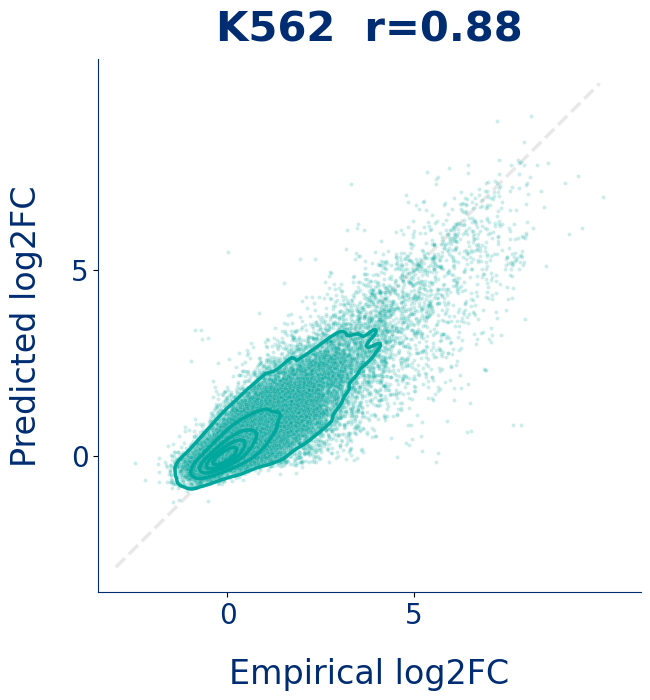

Spearman = 0.83


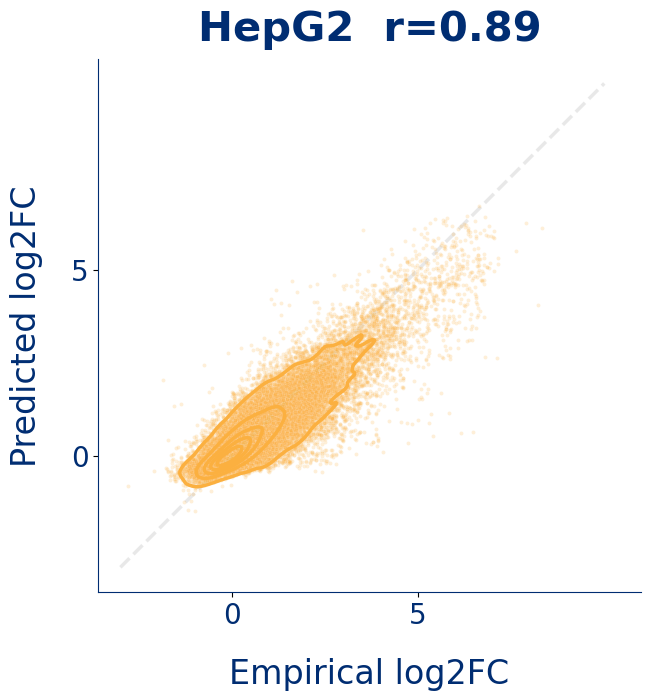

Spearman = 0.83


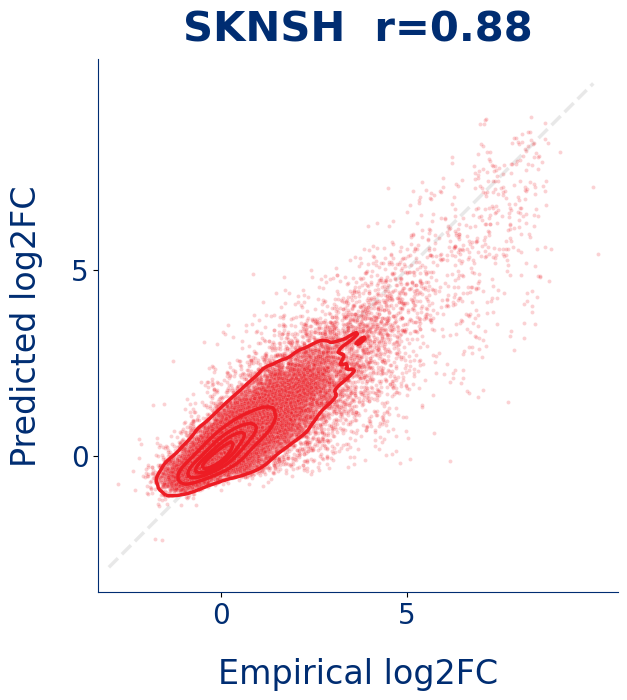

In [9]:
cell_types = ['K562', 'HepG2', 'SKNSH']
colors = ['#00A79D', '#FBB040', '#ED1C24']
#colors = 3*['#0085CA']

for color_idx, cell_type in enumerate(cell_types[:]):
    x_column = f'{cell_type}_mean'
    y_column = f'{cell_type}_pred_aggreg'
    pearson = np.round(test_set_df[x_column].corr(test_set_df[y_column]), 2)
    spearman = np.round(test_set_df[x_column].corr(test_set_df[y_column], method='spearman'), 2)
    print(f'Spearman = {spearman}')
    with plt.style.context('default'): #fivethirtyeight ggplot
        mpl.rc('axes',edgecolor='#002D72')
        mpl.rcParams['lines.linewidth'] = 2.5
        mpl.rcParams['xtick.labelsize'] = 20
        mpl.rcParams['ytick.labelsize'] = 20   
        sns.relplot(data=test_set_df, x=x_column, y=y_column, alpha=0.2, s=8.0, height=6, color= colors[color_idx], zorder=2,
                    rasterized=True)
        sns.kdeplot(data=test_set_df, x=x_column, y=y_column, linestyles="-", color= colors[color_idx],
                    shade=False, levels=6)#np.array([0.05, 0.25, 0.5, 0.75]))
        plt.plot([-3, 10], [-3, 10], linestyle='--', alpha=0.5, color='lightgrey', zorder=0)
        plt.title(f'{cell_type}  r={pearson}', fontsize=30, y=1.02, color='#002D72', weight='bold')
        plt.xlim(-2, 10)
        plt.ylim(-2, 10)
        plt.axis('equal')
        plt.xticks([0, 5], color='#002D72')
        plt.yticks([0, 5], color='#002D72')
        plt.xlabel('Empirical log2FC', fontsize=24, labelpad=20, color='#002D72', weight='normal')
        plt.ylabel('Predicted log2FC', fontsize=24, labelpad=20, color='#002D72', weight='normal')   
        #plt.grid(zorder=0)
#         savepath = f'./figures/testset_prediction_scatter__JAXcolors_{cell_type}.pdf'
#         plt.savefig(savepath, format='pdf', transparent=True, dpi=300, bbox_inches='tight')
        plt.show()
        

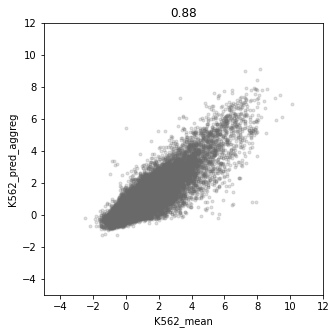

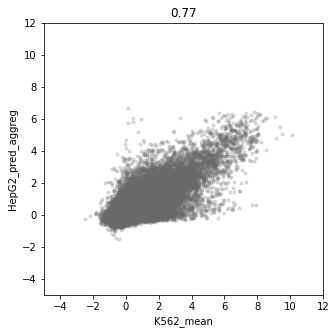

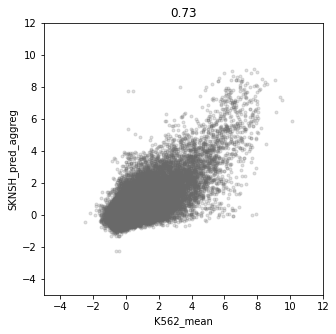

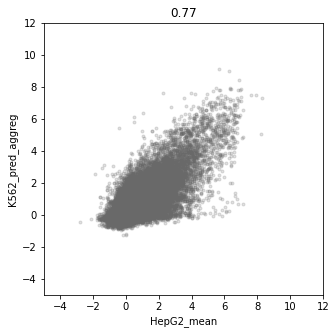

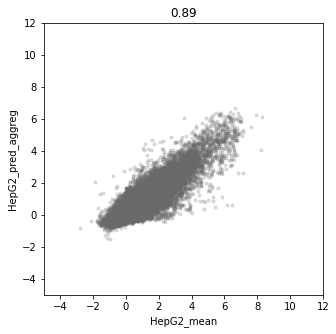

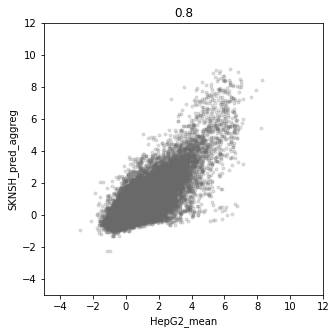

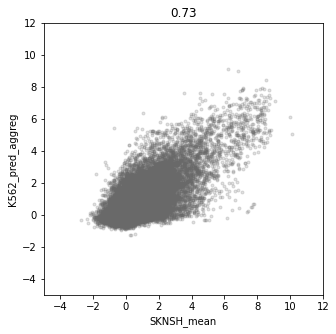

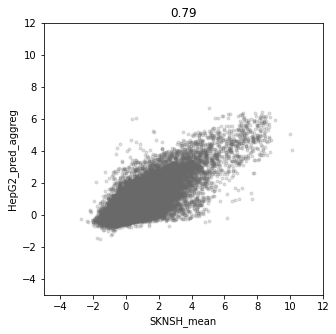

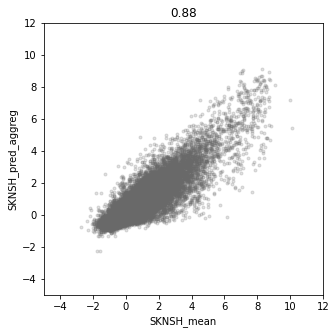

In [11]:
with plt.style.context('fast'):
    for cell_type_1 in cell_types:
        for cell_type_2 in cell_types:
            x_column = f'{cell_type_1}_mean'
            y_column = f'{cell_type_2}_pred_aggreg'
            plt.figure(figsize=(5,5))
            Xs = test_set_df[x_column].to_numpy()
            Ys = test_set_df[y_column].to_numpy()
            pearson  = np.round(stats.pearsonr(Xs, Ys)[0], 2)
            plt.scatter(Xs, Ys, marker='.', alpha=0.2, color='dimgrey', rasterized=True)
            plt.xlim(-5, 12)
            plt.ylim(-5, 12)
            #plt.axis('equal')
            plt.xlabel(x_column)
            plt.ylabel(y_column)
            plt.title(pearson)
            savepath = f'./figures/test_set_exp_vs_exp_vs_pred/{x_column}_vs_{y_column}_{pearson}.pdf'
            plt.savefig(savepath, format='pdf', transparent=True, dpi=300, bbox_inches='tight')
            plt.show()

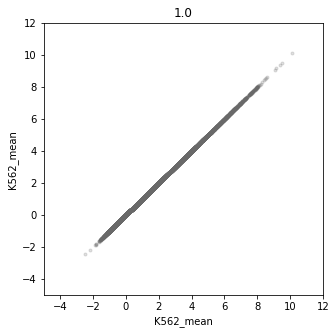

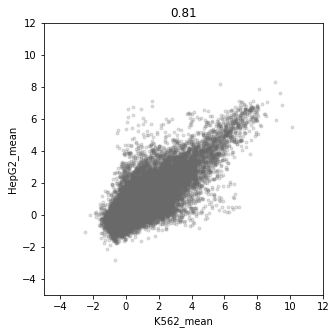

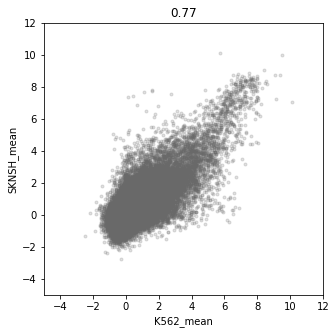

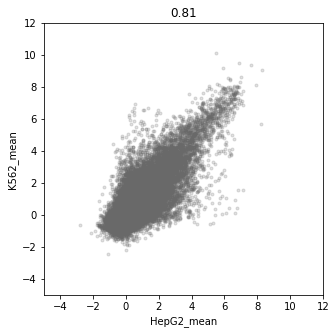

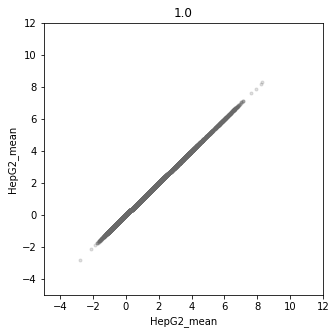

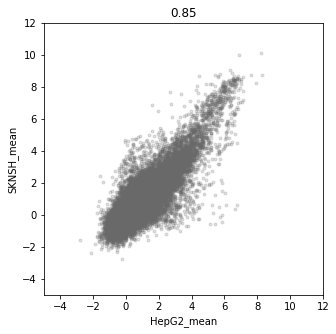

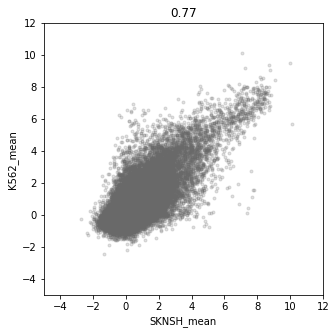

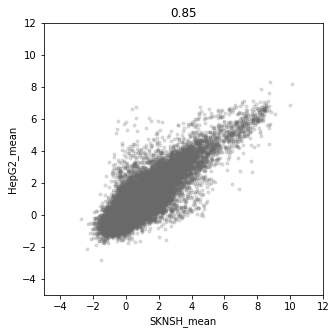

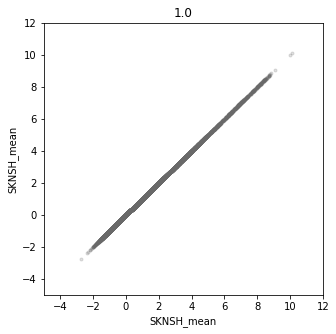

In [12]:
with plt.style.context('fast'):
    for cell_type_1 in cell_types:
        for cell_type_2 in cell_types:
            x_column = f'{cell_type_1}_mean'
            y_column = f'{cell_type_2}_mean'
            plt.figure(figsize=(5,5))
            Xs = test_set_df[x_column].to_numpy()
            Ys = test_set_df[y_column].to_numpy()
            pearson  = np.round(stats.pearsonr(Xs, Ys)[0], 2)
            plt.scatter(Xs, Ys, marker='.', alpha=0.2, color='dimgrey', rasterized=True)
            plt.xlim(-5, 12)
            plt.ylim(-5, 12)
            #plt.axis('equal')
            plt.xlabel(x_column)
            plt.ylabel(y_column)
            plt.title(pearson)
            savepath = f'./figures/test_set_exp_vs_exp_vs_pred/{x_column}_vs_{y_column}_{pearson}.pdf'
            plt.savefig(savepath, format='pdf', transparent=True, dpi=300, bbox_inches='tight')
            plt.show()

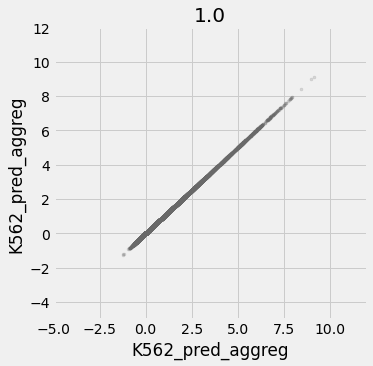

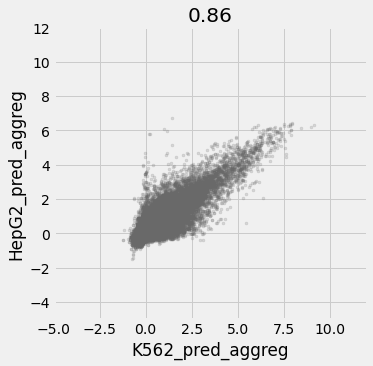

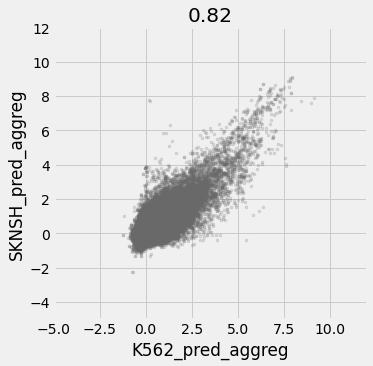

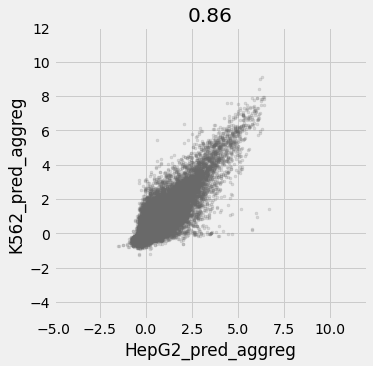

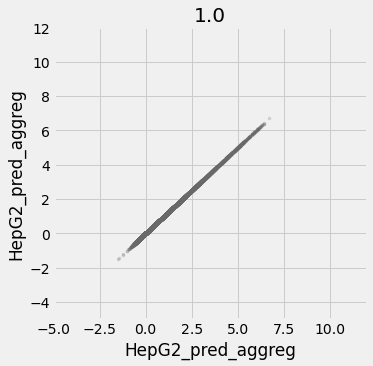

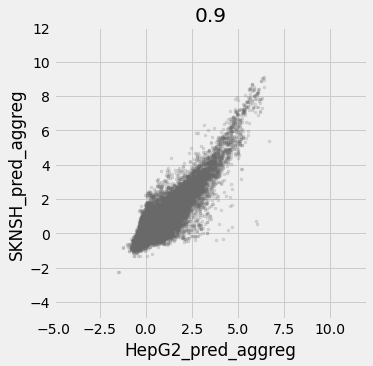

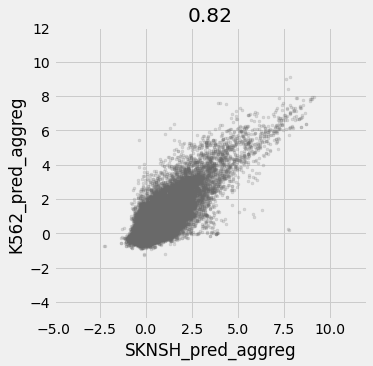

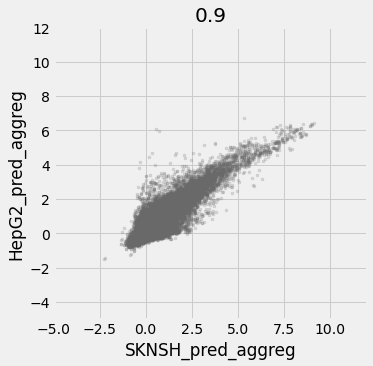

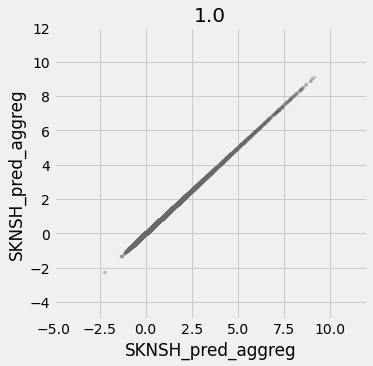

In [20]:
with plt.style.context('fivethirtyeight'):
    for cell_type_1 in cell_types:
        for cell_type_2 in cell_types:
            x_column = f'{cell_type_1}_pred_aggreg'
            y_column = f'{cell_type_2}_pred_aggreg'
            plt.figure(figsize=(5,5))
            Xs = test_set_df[x_column].to_numpy()
            Ys = test_set_df[y_column].to_numpy()
            pearson  = np.round(stats.pearsonr(Xs, Ys)[0], 2)
            plt.scatter(Xs, Ys, marker='.', alpha=0.2, color='dimgrey')
            plt.xlim(-5, 12)
            plt.ylim(-5, 12)
            #plt.axis('equal')
            plt.xlabel(x_column)
            plt.ylabel(y_column)
            plt.title(pearson)
            plt.show()

In [7]:
test_set_df.columns

Index(['HepG2_mean', 'HepG2_std', 'ID_count', 'IDs', 'K562_mean', 'K562_std',
       'OL', 'OL_count', 'SKNSH_mean', 'SKNSH_std', 'chr', 'class',
       'ctrl_mean_hepg2', 'ctrl_mean_k562', 'ctrl_mean_sknsh', 'data_project',
       'exp_mean_hepg2', 'exp_mean_k562', 'exp_mean_sknsh', 'lfcSE_hepg2',
       'lfcSE_k562', 'lfcSE_sknsh', 'nt_sequence', 'padj_hepg2', 'padj_k562',
       'padj_sknsh', 'pvalue_hepg2', 'pvalue_k562', 'pvalue_sknsh',
       'K562_pred', 'HepG2_pred', 'SKNSH_pred', 'K562_pred_rc',
       'HepG2_pred_rc', 'SKNSH_pred_rc', 'K562_pred_aggreg',
       'HepG2_pred_aggreg', 'SKNSH_pred_aggreg'],
      dtype='object')

In [13]:
cell_types = ['K562', 'HepG2', 'SKNSH']
colors = ['#00A79D', '#FBB040', '#ED1C24']
activity_columns = [f'{cell_type}_mean' for cell_type in cell_types]
prediction_columns = [f'{cell_type}_pred_aggreg' for cell_type in cell_types]

test_set_df['max_cell_mpra'] = test_set_df[activity_columns].idxmax(axis=1).str.rstrip('_mean')
test_set_df['max_cell_pred'] = test_set_df[prediction_columns].idxmax(axis=1).str.rstrip('_pred_aggreg')

In [14]:
len(test_set_df[test_set_df['max_cell_mpra'] == test_set_df['max_cell_pred']]) / len(test_set_df)

0.6405196382346362

In [15]:
nontarget_dict = {'K562': ['HepG2_mean', 'SKNSH_mean'],
                 'HepG2': ['K562_mean', 'SKNSH_mean'],
                 'SKNSH': ['K562_mean', 'HepG2_mean']}

target_dict = {'K562': 'K562_mean',
              'HepG2': 'HepG2_mean',
              'SKNSH': 'SKNSH_mean'}

max_cell_column = 'max_cell_mpra'

nontarget_list = []
nontarget_min_list = []
nontarget_min_lfc_list = []
target_lfc_list = []
nontarget_lfc_list = []
for i in tqdm(range(len(test_set_df))):
    temp_row = test_set_df.iloc[[i]]
    nontarget_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].idxmax(axis=1).item())
    nontarget_min_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].idxmin(axis=1).item())
    nontarget_min_lfc_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].min(axis=1).item())
    target_lfc_list.append(temp_row[target_dict[temp_row[max_cell_column].item()]].item())
    nontarget_lfc_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].max(axis=1).item())

  0%|          | 0/62582 [00:00<?, ?it/s]

In [16]:
test_set_df['max_non_target_cell'] = [item.rstrip('_mean').lower() if (type(item) == str) else np.nan for item in nontarget_list]
test_set_df['min_non_target_cell'] = [item.rstrip('_mean').lower() if (type(item) == str) else np.nan for item in nontarget_min_list]
test_set_df['min_non_target_lfc'] = [item if (type(item) == float) else np.nan for item in nontarget_min_lfc_list]
test_set_df['target_cell_lfc'] = [item if (type(item) == float) else np.nan for item in target_lfc_list]
test_set_df['max_non_target_lfc'] = [item if (type(item) == float) else np.nan for item in nontarget_lfc_list]

test_set_df['OverMax_mpra'] = test_set_df['target_cell_lfc'] - test_set_df['max_non_target_lfc']

In [17]:
nontarget_dict = {'K562': ['HepG2_pred_aggreg', 'SKNSH_pred_aggreg'],
                 'HepG2': ['K562_pred_aggreg', 'SKNSH_pred_aggreg'],
                 'SKNSH': ['K562_pred_aggreg', 'HepG2_pred_aggreg']}

target_dict = {'K562': 'K562_pred_aggreg',
              'HepG2': 'HepG2_pred_aggreg',
              'SKNSH': 'SKNSH_pred_aggreg'}

max_cell_column = 'max_cell_pred'

nontarget_list = []
nontarget_min_list = []
nontarget_min_lfc_list = []
target_lfc_list = []
nontarget_lfc_list = []
for i in tqdm(range(len(test_set_df))):
    temp_row = test_set_df.iloc[[i]]
    nontarget_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].idxmax(axis=1).item())
    nontarget_min_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].idxmin(axis=1).item())
    nontarget_min_lfc_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].min(axis=1).item())
    target_lfc_list.append(temp_row[target_dict[temp_row[max_cell_column].item()]].item())
    nontarget_lfc_list.append(temp_row[nontarget_dict[temp_row[max_cell_column].item()]].max(axis=1).item())

  0%|          | 0/62582 [00:00<?, ?it/s]

In [18]:
test_set_df['max_non_target_cell_pred'] = [item.rstrip('_pred_aggreg').lower() if (type(item) == str) else np.nan for item in nontarget_list]
test_set_df['min_non_target_cell_pred'] = [item.rstrip('_pred_aggreg').lower() if (type(item) == str) else np.nan for item in nontarget_min_list]
test_set_df['min_non_target_lfc_pred'] = [item if (type(item) == float) else np.nan for item in nontarget_min_lfc_list]
test_set_df['target_cell_lfc_pred'] = [item if (type(item) == float) else np.nan for item in target_lfc_list]
test_set_df['max_non_target_lfc_pred'] = [item if (type(item) == float) else np.nan for item in nontarget_lfc_list]

test_set_df['OverMax_pred'] = test_set_df['target_cell_lfc_pred'] - test_set_df['max_non_target_lfc_pred']

In [19]:
test_set_df['max cell prediction'] = 'incorrect (36%)'

row_filter = test_set_df['max_cell_mpra'] == test_set_df['max_cell_pred']
test_set_df.loc[row_filter, 'max cell prediction'] = 'correct (64%)'

In [20]:
(row_filter!=True).sum() / len(test_set_df)

0.35948036176536385

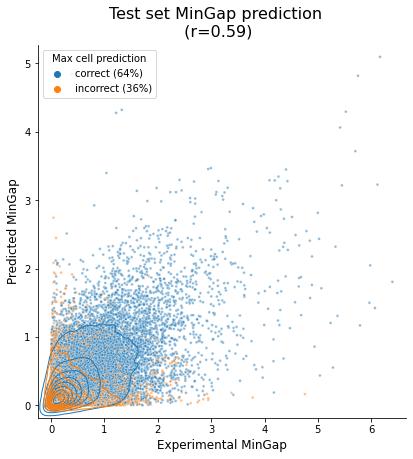

In [22]:
plot_df = test_set_df[test_set_df['OverMax_mpra'] >= 0].reset_index(drop=True)

pearson = np.corrcoef(plot_df['OverMax_mpra'], plot_df['OverMax_pred'])[0,1]

with plt.style.context('fast'):
    mpl.rcParams['lines.linewidth'] = 1
    g = sns.jointplot(data=plot_df, x='OverMax_mpra', y='OverMax_pred', hue='max cell prediction',
                      rasterized=True, marker='.', height=7,# ratio=1, 
                      marginal_kws={'linewidth':2, 'common_grid':False, 'common_norm':True, 'alpha':0.3},
                      joint_kws={'s':30, 'alpha':0.5}
                     )
    g.ax_marg_x.remove()
    g.ax_marg_y.remove()
    g.plot_joint(sns.kdeplot, alpha=1)
#     g.ax_marg_x.set_xlim(0, 7)
#     g.ax_marg_y.set_ylim(0, 10)
    g.set_axis_labels('Experimental MinGap', 'Predicted MinGap', fontsize=12)
#     #plt.title(f'Test set specificity prediction | r={np.round(pearson, 2)}')
#     plt.title(f'Test set specificity prediction (Experimental OverMax >= 1)')
    #plt.title(f'Test set predicted OverMax')
    g.ax_joint.legend(title='Max cell prediction', loc=2)
    g.fig.suptitle(f'Test set MinGap prediction\n (r={np.round(pearson, 2)})', x=0.45, y=0.9, fontsize=16)
    savepath = f'./figures/test_set_specificity_prediction.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

In [23]:
len(plot_df[plot_df['max_cell_mpra'] == plot_df['max_cell_pred']]) / len(plot_df)

0.6405196382346362

In [23]:
len(plot_df[plot_df['max_cell_mpra'] == plot_df['max_cell_pred']]) / len(plot_df)

0.6405196382346362

In [24]:
len(plot_df) / len(test_set_df)

1.0

In [25]:
pearson

0.5878888158256357

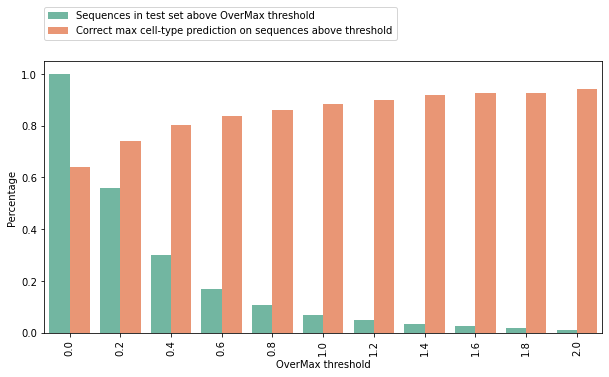

In [26]:
pct_specific = []
pct_correctly = []
thresholds = np.linspace(0,2,11)
#thresholds = np.quantile(test_set_df['OverMax_mpra'] , np.linspace(0.01,0.99,10))
rounded_thresholds = [np.round(x,2) for x in thresholds]
for threshold in rounded_thresholds:
    plot_df = test_set_df[test_set_df['OverMax_mpra'] >= threshold].reset_index(drop=True)
    pct_specific.append(len(plot_df) / len(test_set_df))
    pct_correctly.append(len(plot_df[plot_df['max_cell_mpra'] == plot_df['max_cell_pred']]) / len(plot_df))
    
temp_df = pd.DataFrame([pct_specific + pct_correctly,
                    len(thresholds)*['Sequences in test set above OverMax threshold'] + len(thresholds)*['Correct max cell-type prediction on sequences above threshold'],
                    2*rounded_thresholds
                   ]).T

with plt.style.context('fast'):
    plt.figure(figsize=(10,5))
    g = sns.barplot(data=temp_df, x=2, y=0, hue=1, palette="Set2")
    plt.xticks(rotation=90)
    plt.xlabel('OverMax threshold')
    plt.ylabel('Percentage')
    plt.legend(title='')
    #plt.title('Test set cell-specificity prediction performance')
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.legend(bbox_to_anchor=(0, 1.2), loc=2, borderaxespad=0.)
    plt.show()

In [27]:
pct_specific = []
pct_correct = []
pct_incorrect = []
thresholds = np.linspace(0,2,11)
#thresholds = np.quantile(test_set_df['OverMax_mpra'] , np.linspace(0.01,0.99,10))
rounded_thresholds = [np.round(x,2) for x in thresholds]
for threshold in rounded_thresholds:
    plot_df = test_set_df[test_set_df['OverMax_mpra'] >= threshold].reset_index(drop=True)
    pct_specific.append(len(plot_df) / len(test_set_df))
    pct_correct.append(len(plot_df[plot_df['max_cell_mpra'] == plot_df['max_cell_pred']]) / len(test_set_df))
    pct_incorrect.append(len(plot_df[plot_df['max_cell_mpra'] != plot_df['max_cell_pred']]) / len(test_set_df))

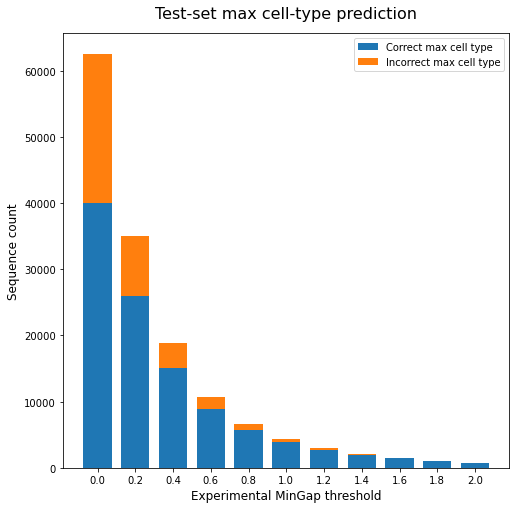

In [31]:
pct_specific = []
pct_correct = []
pct_incorrect = []
thresholds = np.linspace(0,2,11)
#thresholds = np.quantile(test_set_df['OverMax_mpra'] , np.linspace(0.01,0.99,10))
rounded_thresholds = [np.round(x,2) for x in thresholds]
for threshold in rounded_thresholds:
    plot_df = test_set_df[test_set_df['OverMax_mpra'] >= threshold].reset_index(drop=True)
    pct_specific.append(len(plot_df) / len(test_set_df))
    pct_correct.append(len(plot_df[plot_df['max_cell_mpra'] == plot_df['max_cell_pred']]))
    pct_incorrect.append(len(plot_df[plot_df['max_cell_mpra'] != plot_df['max_cell_pred']]))
    
weight_counts = {
    "Correct max cell type": np.array(pct_correct),
    "Incorrect max cell type": np.array(pct_incorrect),
}

width = 0.15

with plt.style.context('fast'):
    fig, ax = plt.subplots(figsize=(8,8))
    bottom = np.zeros(len(rounded_thresholds))

    for boolean, weight_count in weight_counts.items():
        p = ax.bar(rounded_thresholds, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count
    ax.vlines(0.9, 0, 1, color='black', linestyle='dashed', zorder=1, alpha=.2)
    # ax.set_title("Number of penguins with above average body mass")
    ax.legend(loc="upper right")
    plt.xticks(rounded_thresholds)
    plt.xlabel('Experimental MinGap threshold', fontsize=12)
    plt.ylabel('Sequence count', fontsize=12)
    plt.title('Test-set max cell-type prediction', y=1.02, fontsize=16)
    savepath = f'./figures/test_set_max_prediction.pdf'
    plt.savefig(savepath, format='pdf', transparent=True, dpi=150, bbox_inches='tight')
    plt.show()

In [364]:
for boolean, weight_count in weight_counts.items():
    print(boolean, weight_count)

Correct max cell type [0.64051964 0.41427247 0.24174683 0.14296443 0.0907769  0.06164712
 0.04311144 0.0308715  0.02288198 0.01613883 0.01177655]
Incorrect max cell type [0.35948036 0.14422677 0.05905852 0.02754786 0.01470071 0.00806941
 0.00485763 0.00276437 0.00180563 0.00126234 0.00070308]


In [438]:
fimo_df = pd.read_csv('/Users/castrr/Dropbox (JAX)/Datasets/BODA2/STREME_global_analysis/fimo_min8.tsv', sep='\t')
fimo_df = fimo_df[:-3].reset_index(drop=True)

In [447]:
total_hits = 120000 #len(fimo_df)
for motif_id in sorted(fimo_df['motif_alt_id'].unique()):
    num_hits = np.round(100 * len(fimo_df[fimo_df['motif_alt_id'] == motif_id]) / total_hits, 2)
    #if num_hits == 0:
    print(motif_id, num_hits)

STREME-1 44.81
STREME-10 27.58
STREME-11 17.41
STREME-12 25.19
STREME-13 31.1
STREME-14 27.6
STREME-15 8.67
STREME-16 12.3
STREME-17 14.33
STREME-18 8.69
STREME-19 23.3
STREME-2 34.87
STREME-20 11.62
STREME-21 7.68
STREME-22 22.22
STREME-23 15.74
STREME-24 5.77
STREME-25 14.92
STREME-26 16.88
STREME-27 10.18
STREME-28 14.74
STREME-29 10.1
STREME-3 24.72
STREME-30 14.43
STREME-31 8.37
STREME-32 4.36
STREME-33 11.0
STREME-34 13.8
STREME-35 50.84
STREME-36 10.43
STREME-37 12.26
STREME-38 9.74
STREME-39 8.45
STREME-4 28.65
STREME-40 5.77
STREME-41 16.22
STREME-42 8.47
STREME-43 5.23
STREME-44 10.86
STREME-45 56.7
STREME-46 14.68
STREME-47 5.12
STREME-48 47.37
STREME-49 53.68
STREME-5 38.42
STREME-50 6.8
STREME-51 53.28
STREME-52 5.25
STREME-53 6.23
STREME-54 4.25
STREME-55 13.12
STREME-56 9.54
STREME-57 6.98
STREME-58 4.56
STREME-59 2.41
STREME-6 24.16
STREME-60 4.67
STREME-61 14.6
STREME-62 14.32
STREME-63 4.63
STREME-64 3.24
STREME-65 52.47
STREME-66 7.69
STREME-67 4.24
STREME-68 8.26
ST

In [539]:
projected_money_4years = 1.15*72000 + 125000 + 1.03*125000 + 1.03*(1.03*125000)

print(f'01/2023-12/2026 projected salary (with JAX scholar): ${projected_money_4years}')

01/2023-12/2026 projected salary (with JAX scholar): $469162.5


In [540]:
projected_money_4years = 72000 + 125000 + 1.03*125000 + 1.03*(1.03*125000)

print(f'01/2023-12/2026 projected salary: ${projected_money_4years}')

01/2023-12/2026 projected salary: $458362.5


In [541]:
new_salary = 113000
total_new_money = 4/12*72000 + 8/12*new_salary + 1.03*new_salary + 1.03*(1.03*new_salary) + 1.03*1.03*(1.03*new_salary)

print(f'01/2023-12/2026 projected salary: ${total_new_money}')

01/2023-12/2026 projected salary: $459083.18433333334


In [543]:
new_salary = 115000
total_new_money = 4/12*72000 + 8/12*new_salary + 1.03*new_salary + 1.03*(1.03*new_salary) + 1.03*1.03*(1.03*new_salary)

print(f'01/2023-12/2026 projected salary: ${total_new_money}')

01/2023-12/2026 projected salary: $466783.7716666666


In [479]:
(projected_money_4years - 72000/12 * 4) / (36 + 8)

9871.875

In [477]:
(0.7*total_new_money / 48)/3

2272.048657407407

In [526]:
(0.72*113000/12)

6780.0

In [499]:
1.03*1.03*(1.03*new_salary), 1.03*(1.03*125000)

(123478.151, 132612.5)

In [524]:
(0.72*115000/365)*28 - 2150

4201.780821917809

In [529]:
1.15 * 72000

82800.0